# Import Modules

In [2]:
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from pylab import *
def figpath(name):
    folder = '../../Composites Project/figures/'
    return folder + name
def graph_setup(w,h):
    plt.style.use('default')
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.family'] = 'Helvetica'
    fig = plt.figure(figsize=(w,h))
    return fig
def set_widths(ax_):
    for i in ["top","left","right","bottom"]:
        ax_.spines[i].set_linewidth(.5)
    ax_.tick_params(width=.5,bottom=True, top=True, left=True, right=True,direction="in")
def save_graph(name,fig,form):
#     plt.tight_layout()
    fig.savefig(figpath(name), format=form,bbox_inches='tight',dpi=300)
def leg_setup(legend):
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(.5)


# Read and Process Data

In [4]:
dropping = ["Volume Fraction","Matrix Material","Filler Material","Matrix Density (kg/m^3)","Filler Density (kg/m^3)"]
individual = ["Volume Fraction","Matrix Density (kg/m^3)","Filler Density (kg/m^3)"]

In [5]:
df = pd.read_excel('red_results_9_22.xlsx').dropna(how='all')
datadf = df
# X_df = datadf.iloc[:,np.concatenate([[0,3,4],np.arange(5,20)])]
X_df = datadf.iloc[:,np.arange(0,19)]
y_df = datadf.iloc[:,np.arange(19,24)]
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, random_state=3, test_size=0.15)

# y_test_real = X_test_df.iloc[:,np.arange(3,16)]
MPD_train = X_train_df.drop(columns=dropping)
vf_train = X_train_df.loc[:,individual].values

MPD_test = X_test_df.drop(columns=dropping)
vf_test = X_test_df.loc[:,individual].values

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# y is input, mech responses
y_scaler = StandardScaler()
y_scaler.fit(y_train_df)
y_train = y_scaler.transform(y_train_df)
y_test = y_scaler.transform(y_test_df)

y_minmax_scaler = MinMaxScaler()
y_minmax_scaler.fit(y_train)

# MPD is output
MPD_scaler = StandardScaler()
MPD_scaler.fit(MPD_train)
MPD_train = MPD_scaler.transform(MPD_train)
MPD_test = MPD_scaler.transform(MPD_test)


In [7]:
X_train_df

,Volume Fraction,Matrix Material,Filler Material,Matrix Density (kg/m^3),Matrix Elastic Modulus (MPa),Matrix Poisson's Ratio,Matrix Yield Strength (MPa),Matrix Hardening Parameter,Temperature (K),Filler Density (kg/m^3),Filler Elastic Modulus 1,Filler Elastic Modulus 2,Filler Elastic Modulus 3,Filler Poisson 1,Filler Poisson 2,Filler Poisson 3,Filler Shear 1,Filler Shear 2,Filler Shear 3
2803,0.04,PMMA,S-Glass,1180,2742.622951,0.36,149.590164,0.431152,273,2530,85000,85000,85000,0.35,0.35,0.35,36000,36000,36000
1902,0.03,PC,S-Glass,1200,1396.551724,0.37,62.068966,0.346699,333,2530,85000,85000,85000,0.35,0.35,0.35,36000,36000,36000
1210,0.11,PC,Carbon,1200,1075.862069,0.37,46.551724,0.285244,393,1770,220000,14000,14000,0.20,0.20,0.25,9000,9000,4600
1927,0.28,PC,S-Glass,1200,1396.551724,0.37,62.068966,0.346699,333,2530,85000,85000,85000,0.35,0.35,0.35,36000,36000,36000
2340,0.41,PMMA,E-Glass,1180,2742.622951,0.36,149.590164,0.431152,273,2540,75000,75000,75000,0.20,0.20,0.22,30000,30000,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,0.05,PMMA,E-Glass,1180,2742.622951,0.36,149.590164,0.431152,273,2540,75000,75000,75000,0.20,0.20,0.22,30000,30000,30000
968,0.19,PAI,S-Glass,1490,1152.542373,0.38,43.032787,0.277231,393,2530,85000,85000,85000,0.35,0.35,0.35,36000,36000,36000
1667,0.18,PC,Kevlar,1200,1396.551724,0.37,62.068966,0.346699,333,1470,150000,4200,4200,0.35,0.35,0.35,2900,2900,1500
1688,0.39,PC,Kevlar,1200,1396.551724,0.37,62.068966,0.346699,333,1470,150000,4200,4200,0.35,0.35,0.35,2900,2900,1500


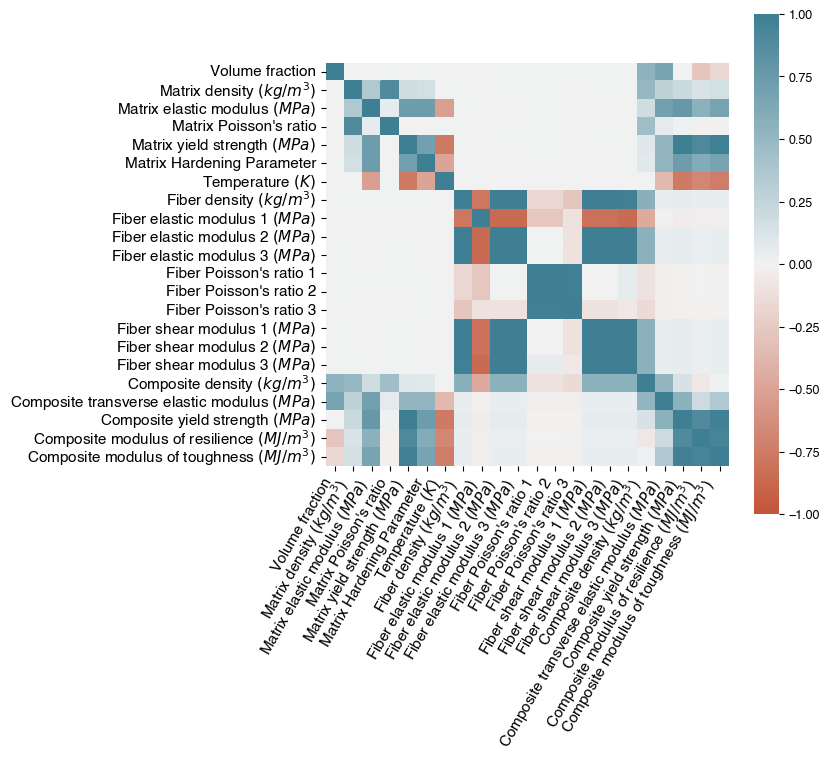

In [167]:
# correlation matrix
import seaborn as sns
corr = datadf.corr()
fig = graph_setup(6.5,6.5)
ax = fig.add_subplot(111)
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ticknames = ['Volume fraction', 'Matrix density $(kg/m^3)$', 
             'Matrix elastic modulus $(MPa)$','Matrix Poisson\'s ratio','Matrix yield strength $(MPa)$',
             'Matrix Hardening Parameter','Temperature $(K)$','Fiber density $(kg/m^3)$',
             'Fiber elastic modulus 1 $(MPa)$','Fiber elastic modulus 2 $(MPa)$','Fiber elastic modulus 3 $(MPa)$',
             'Fiber Poisson\'s ratio 1','Fiber Poisson\'s ratio 2','Fiber Poisson\'s ratio 3',
             'Fiber shear modulus 1 $(MPa)$','Fiber shear modulus 2 $(MPa)$','Fiber shear modulus 3 $(MPa)$',
             'Composite density $(kg/m^3)$', 'Composite transverse elastic modulus $(MPa)$',
             'Composite yield strength $(MPa)$',
             'Composite modulus of resilience $(MJ/m^3)$','Composite modulus of toughness $(MJ/m^3)$']
ax.set_xticklabels(
    ticknames,
    rotation=60,
    horizontalalignment='right',
    fontsize=11);
ax.set_yticklabels(
    ticknames,
    fontsize=11);
plt.rcParams.update({'font.size': 8})
save_graph('corr_mat.eps',fig,'eps')

In [ ]:
# Min and Max
pd.set_option("display.max_rows", None, "display.max_columns", None)
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])
datadf.apply(minMax)

[4.09416217e-01 2.16477369e-01 2.12984078e-01 7.16095372e-02
 4.17099457e-02 1.91026721e-02 1.72251571e-02 1.14750246e-02
 2.07901558e-31 2.85918865e-32 5.56430028e-33 7.32352012e-34
 1.34661745e-34 3.29280721e-35]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
cumulative sum of variance ratios: 0.4094162169036721 0.6258935855156044 0.8388776633379681 0.9104872005084184 0.9521971462229004 0.9712998183034063 0.9885249754196478 1.0 1.0 1.0 1.0 1.0 1.0 1.0


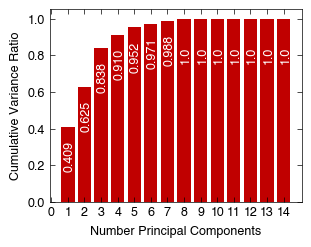

In [8]:
# cumulative variance ratio
fig = graph_setup(3.25,2.5)
ax = fig.add_subplot(111)
MPDt_pca = PCA()
MPDt_pca.fit(MPD_train)
print(MPDt_pca.explained_variance_ratio_)
y = np.cumsum(MPDt_pca.explained_variance_ratio_)
x = np.arange(1,np.shape(MPD_train)[1]+1)
print(x)
ax.bar(x,y,color='#c00000')
ax.set_xlabel('Number Principal Components')
ax.set_ylabel('Cumulative Variance Ratio')
set_widths(ax)
for i, txt in enumerate(y):
    txt = str(txt)[0:5]
    ax.annotate(txt, xy=(x[i], y[i]), textcoords="offset points", xytext = (-3,-30),rotation=90,color='white')
xint = range(np.shape(MPD_train)[1]+1)
matplotlib.pyplot.xticks(xint)
print('cumulative sum of variance ratios:',*np.cumsum(MPDt_pca.explained_variance_ratio_))
save_graph('explainedvarrat_allPCA.eps',fig,'eps')
plt.show()

[4.09416217e-01 2.16477369e-01 2.12984078e-01 7.16095372e-02
 4.17099457e-02 1.91026721e-02 1.72251571e-02 1.14750246e-02
 2.07901558e-31 2.85918865e-32 5.56430028e-33 7.32352012e-34
 1.34661745e-34 3.29280721e-35]
Eigenvalues: 5.7340756937862265 3.031872130029808 2.982946872600386 1.0029268250235677 0.5841683256206389 0.2675423276869599 0.24124680621805522 0.16071336897550967 2.9117636837129022e-30 4.0044344772699525e-31 7.793076502924864e-32 1.0256950501013796e-32 1.8860040333192393e-33 4.611738617702639e-34


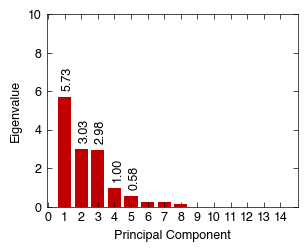

In [9]:
# eigenvalues
fig = graph_setup(3.25,2.5)
ax = fig.add_subplot(111)
MPDt_pca = PCA()
MPDt_pca.fit(MPD_train)
print(MPDt_pca.explained_variance_ratio_)
x = np.arange(1,np.shape(MPD_train)[1]+1)
y = MPDt_pca.explained_variance_
ax.bar(x,y,color='#c00000')
# plt.title('Eigenvalues of Principal Components', fontweight='bold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
for i, txt in enumerate(y):
    txt = str(txt)[0:4]
    if i == 5:
        break
    plt.annotate(txt, xy=(x[i], y[i]), textcoords="offset points", xytext = (-2,6),rotation = 90)
plt.ylim(0,10)
print('Eigenvalues:',*MPDt_pca.explained_variance_)
xint = range(np.shape(MPD_train)[1]+1)
matplotlib.pyplot.xticks(xint)
set_widths(ax)
save_graph('eigenvals_allPCA.eps',fig,'eps')

In [10]:
# Train
MPD_pca = PCA(n_components=4)
MPD_pca.fit(MPD_train)
MPD_train = MPD_pca.transform(MPD_train)
MPD_test = MPD_pca.transform(MPD_test)
print("MPD PCA variance ratio:",MPD_pca.explained_variance_ratio_)

MPD PCA variance ratio: [0.40941622 0.21647737 0.21298408 0.07160954]


In [11]:
X_train = np.hstack([vf_train,MPD_train])
X_test = np.hstack([vf_test,MPD_test])

X_scaler = MinMaxScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('np.shape(y_train) = ',np.shape(y_train))
print('np.shape(X_train) = ',np.shape(X_train))

# flip assignments
temp_train = X_train
temp_test = X_test
X_train = y_train
X_test = y_test
y_train = temp_train
y_test = temp_test
print('np.shape(y_train) = ',np.shape(y_train))
print('np.shape(X_train) = ',np.shape(X_train))

print('np.shape(y_test) = ',np.shape(y_test))
print('np.shape(X_test) = ',np.shape(X_test))
print(X_train)
print(y_train)

np.shape(y_train) =  (2550, 5)
np.shape(X_train) =  (2550, 7)
np.shape(y_train) =  (2550, 7)
np.shape(X_train) =  (2550, 5)
np.shape(y_test) =  (450, 7)
np.shape(X_test) =  (450, 5)
[[-1.2349464  -0.25677472  0.93766452  1.1457952   1.02776678]
 [-1.20657693 -1.23115363 -0.63525153 -0.24931126 -0.4704999 ]
 [-1.09694575 -1.35467708 -1.00355254 -0.60936331 -0.78243149]
 ...
 [-1.16474398 -0.9801849  -0.81406338 -0.57358717 -0.6619418 ]
 [-0.89210854 -0.23735331 -0.82165702 -0.74023437 -0.83494655]
 [ 1.73519306  0.81669857 -0.52205976 -0.70548888 -0.7796409 ]]
[[0.06122449 0.         0.99065421 ... 0.87852697 0.60135748 0.0435912 ]
 [0.04081633 0.06451613 0.99065421 ... 0.74614697 0.19010812 0.49144924]
 [0.20408163 0.06451613 0.28037383 ... 0.03625515 0.13872048 0.52130574]
 ...
 [0.34693878 0.06451613 0.         ... 0.77406726 0.18061945 0.48683392]
 [0.7755102  0.06451613 0.         ... 0.77406726 0.18061945 0.48683392]
 [0.97959184 0.06451613 0.99065421 ... 0.81898847 0.41391745 0.4

## Graphs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

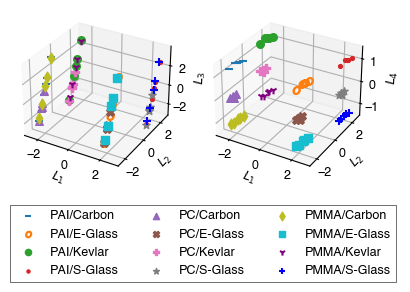

In [121]:
# plot Latent Space
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('default')
markers = ['_','$O$','o','.','^','X','P','*','d','s','1','+']
labels = ['PAI/Carbon','PAI/E-Glass','PAI/Kevlar','PAI/S-Glass',
          'PC/Carbon','PC/E-Glass','PC/Kevlar','PC/S-Glass',
          'PMMA/Carbon','PMMA/E-Glass','PMMA/Kevlar','PMMA/S-Glass']
# names = ['epoxy carbon','epoxy glass','epoxy kevlar',
#           'PMMA carbon','PMMA glass','PMMA kevlar',
#           'PET carbon','PET glass','PET kevlar']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray',
         'tab:olive','tab:cyan','purple','b']
# lower in cluster is higher temperature

# fig = plt.figure(figsize=(6,12))
fig0 = graph_setup(6,3.25)

ax0 = fig0.add_subplot(131,projection='3d')
ax2 = fig0.add_subplot(132,projection='3d')

proj2d_0 = 0
proj2d_1 = 1

MPD_all = MPD_pca.transform(MPD_scaler.transform(X_df.drop(columns=dropping)))
seen = set()

for i,val in enumerate(MPD_all):
    go = True
    for ls in seen:
        if all(MPD_all[i,:] == ls):
            go = False
            break
    
    if not go:
        continue
    else:
        seen.add(tuple(MPD_all[i,:]))
        matrix = datadf.iloc[i,[1]].tolist()
        filler = datadf.iloc[i,[2]].tolist()
        material = matrix[0] + "/" + filler[0]
        for n, lab in enumerate(labels):
            if lab == material:
                break
        ax0.scatter(MPD_all[i,0],MPD_all[i,1],MPD_all[i,2],s=30,color=colors[n],marker=markers[n])
        ax2.scatter(MPD_all[i,0],MPD_all[i,1],MPD_all[i,3],s=30,color=colors[n],marker=markers[n])

lpad = -7
tpad = -3
# ax0.view_init(elev=30, azim=30)
ax0.set_xlabel('$L_1$',labelpad=lpad)
ax0.set_ylabel('$L_2$',labelpad=lpad)
ax0.set_zlabel('$L_3$',labelpad=lpad)

# ax2.view_init(elev=30, azim=30)
ax2.set_xlabel('$L_1$',labelpad=lpad)
ax2.set_ylabel('$L_2$',labelpad=lpad)
ax2.set_zlabel('$L_4$',labelpad=lpad)

set_widths(ax0)
set_widths(ax2)
set_widths(ax1)
ax0.tick_params(axis='both',pad=tpad)
ax2.tick_params(axis='both',pad=tpad)

[ax0.scatter([], [], color=colors[i], marker=markers[i], label=labels[i]) for i in range(len(labels))]
leg_handles, leg_labels = ax0.get_legend_handles_labels()
leg0 = fig0.legend(leg_handles, leg_labels, loc='lower center', fancybox=False,ncol=3,bbox_to_anchor=(.36, -.1))
leg0.get_frame().set_edgecolor('k')
leg0.get_frame().set_linewidth(.5)

# plt.axis('square')
plt.tight_layout(pad=2)
save_graph('LMPS_allPCA.eps',fig0,'eps')
plt.show()

# E/C NN

In [ ]:
ECdata = datadf[(datadf['Matrix Material'] == 'epoxy') & (datadf['Filler Material'] == 'carbon')]
ECdata

ECy_df = datadf.iloc[:,np.arange(0,18)]
ECx_df = datadf.iloc[:,np.arange(18,23)]
from sklearn.model_selection import train_test_split
ECx_train_df, ECx_test_df, ECy_train_df, ECy_test_df = train_test_split(ECx_df, ECy_df, random_state=2, test_size=0.15)
ECMPD_train = ECy_train_df.drop(columns=["Matrix Material","Filler Material"])
ECMPD_test = ECy_test_df.drop(columns=["Matrix Material","Filler Material"])

ECx_scaler = StandardScaler()
ECx_scaler.fit(ECx_train_df)
ECx_train = ECx_scaler.transform(ECx_train_df)
ECx_test = ECx_scaler.transform(ECx_test_df)

ECMPD_scaler = StandardScaler()
ECMPD_scaler.fit(ECMPD_train)
ECMPD_train = ECMPD_scaler.transform(ECMPD_train)
ECMPD_test = ECMPD_scaler.transform(ECMPD_test)

In [ ]:
# Train
ECMPD_pca = PCA(n_components=4)
ECMPD_pca.fit(ECMPD_train)
ECMPD_train = ECMPD_pca.transform(ECMPD_train)
ECMPD_test = ECMPD_pca.transform(ECMPD_test)
print("MPD PCA variance ratio:",ECMPD_pca.explained_variance_ratio_)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('default')
markers = ['_','$O$','o','.','^','X','P','*','d','s','1','+']
labels = ['Epoxy-Carbon','Epoxy-Glass','Epoxy-Kevlar']
names = ['epoxy carbon','epoxy glass','epoxy kevlar']
colors = ['tab:blue','tab:orange','tab:green']
# lower in cluster is higher temperature

# fig = plt.figure(figsize=(6,12))
fig0 = graph_setup(6.5,3.5)

ax0 = fig0.add_subplot(131,projection='3d')
ax2 = fig0.add_subplot(132,projection='3d')
ax1 = fig0.add_subplot(133)
proj2d_0 = 0
proj2d_1 = 1
MPD_all = ECMPD_pca.transform(ECMPD_scaler.transform(ECy_df.drop(columns=["Matrix Material","Filler Material"])))
for i,val in enumerate(MPD_all):
    matrix = ECdata.iloc[i,[1]].tolist()
    filler = ECdata.iloc[i,[2]].tolist()
    material = matrix[0] + " " + filler[0]
    for n, lab in enumerate(names):
        if lab == material:
            break
    ax0.scatter(MPD_all[i,0],MPD_all[i,1],MPD_all[i,2],s=30,color=colors[n],marker=markers[n])
    ax2.scatter(MPD_all[i,0],MPD_all[i,1],MPD_all[i,3],s=30,color=colors[n],marker=markers[n])
    ax1.scatter(MPD_all[i,proj2d_0],MPD_all[i,proj2d_1],s=30,color=colors[n],marker=markers[n])

lpad = -7
tpad = -3
ax0.view_init(elev=30, azim=30)
ax0.set_xlabel('$L_1$',labelpad=lpad)
ax0.set_ylabel('$L_2$',labelpad=lpad)
ax0.set_zlabel('$L_3$',labelpad=lpad)

ax2.view_init(elev=30, azim=30)
ax2.set_xlabel('$L_1$',labelpad=lpad)
ax2.set_ylabel('$L_2$',labelpad=lpad)
ax2.set_zlabel('$L_4$',labelpad=lpad)

lab1 = r'$L_{}$'.format(proj2d_0+1)
lab2 = r'$L_{}$'.format(proj2d_1+1)

ax1.set_xlabel(lab1)
ax1.set_ylabel(lab2)

set_widths(ax0)
set_widths(ax2)
set_widths(ax1)
ax0.tick_params(axis='both',pad=tpad)
ax2.tick_params(axis='both',pad=tpad)

[ax0.scatter([], [], color=colors[i], marker=markers[i], label=labels[i]) for i in range(9)]
leg_handles, leg_labels = ax0.get_legend_handles_labels()
leg0 = fig0.legend(leg_handles, leg_labels, loc='lower center', fancybox=False,ncol=3)
leg0.get_frame().set_edgecolor('k')
leg0.get_frame().set_linewidth(.5)

plt.axis('square')
plt.tight_layout()
save_graph('LMPS_allPCA.eps',fig0,'eps')
plt.show()

In [ ]:
def Net(neurons=50,hidden_act='softmax',final_act='tanh', opt='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=5, activation=hidden_act))
    model.add(Dense(neurons, kernel_initializer="normal", activation=hidden_act))
    model.add(Dense(neurons, kernel_initializer="normal", activation=hidden_act))
    model.add(Dropout(0.1))
    model.add(Dense(4, kernel_initializer="normal", activation=final_act))
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model

In [ ]:
estimator = KerasRegressor(build_fn=Net, epochs=10000, batch_size=32)
es = EarlyStopping(monitor='val_loss', mode='min', patience=1000, restore_best_weights=True, verbose=1)
history = estimator.fit(ECx_train, ECMPD_train,validation_split=15/85, callbacks=[es], verbose=0)
testresults = estimator.score(ECx_test, ECMPD_test)
print(testresults)

# Neural Network

In [12]:
def Net(neurons=45,hidden_act='sigmoid',final_act='tanh', opt='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=5, activation=hidden_act))
    model.add(Dense(neurons, kernel_initializer="normal", activation=hidden_act))
    model.add(Dense(neurons, kernel_initializer="normal", activation=hidden_act))
    model.add(Dropout(0.1))
    model.add(Dense(7, kernel_initializer="normal", activation=final_act))
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model

## Training

In [111]:
estimator = KerasRegressor(build_fn=Net, epochs=10000, batch_size=32)
es = EarlyStopping(monitor='val_loss', mode='min', patience=1000, restore_best_weights=True, verbose=1)
history = estimator.fit(X_train, y_train,validation_split=15/85, callbacks=[es], verbose=1)
testresults = estimator.score(X_test, y_test)
print(testresults)

Epoch 1/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.2094 - val_loss: 0.1487
Epoch 2/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1506 - val_loss: 0.1485
Epoch 3/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1501 - val_loss: 0.1472
Epoch 4/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1481 - val_loss: 0.1444
Epoch 5/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1430 - val_loss: 0.1362
Epoch 6/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1349 - val_loss: 0.1292
Epoch 7/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.1234
Epoch 8/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1240 - val_loss: 0.1186
Epoch 9/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1191 - val_loss: 0.1125
Epoch 10/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.1144 - val_lo

Epoch 161/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0464 - val_loss: 0.0445
Epoch 162/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0460 - val_loss: 0.0445
Epoch 163/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0462 - val_loss: 0.0450
Epoch 164/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0442
Epoch 165/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0452
Epoch 166/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0441
Epoch 167/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0436
Epoch 168/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0440
Epoch 169/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0436
Epoch 170/10000
66/66 [==============================] - 0s 2ms/step - lo

66/66 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0342
Epoch 320/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0342
Epoch 321/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0342
Epoch 322/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0341
Epoch 323/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0344
Epoch 324/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0339
Epoch 325/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0338
Epoch 326/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0340
Epoch 327/10000
66/66 [==============================] - 0s 4ms/step - loss: 0.0347 - val_loss: 0.0336
Epoch 328/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0346 - val

66/66 [==============================] - 0s 3ms/step - loss: 0.0293 - val_loss: 0.0276
Epoch 478/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0277
Epoch 479/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0276
Epoch 480/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0272
Epoch 481/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0275
Epoch 482/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0274
Epoch 483/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0273
Epoch 484/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0274
Epoch 485/10000
66/66 [==============================] - 0s 4ms/step - loss: 0.0296 - val_loss: 0.0275
Epoch 486/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0293 - val

Epoch 634/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0242
Epoch 635/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0238
Epoch 636/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0238
Epoch 637/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0239
Epoch 638/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0236
Epoch 639/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 640/10000
66/66 [==============================] - 0s 6ms/step - loss: 0.0252 - val_loss: 0.0239
Epoch 641/10000
66/66 [==============================] - 0s 4ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 642/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0237
Epoch 643/10000
66/66 [==============================] - 0s 6ms/step - lo

66/66 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0215
Epoch 793/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0222
Epoch 794/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 795/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0216
Epoch 796/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0217
Epoch 797/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 798/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 799/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 800/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0215
Epoch 801/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0225 - val

66/66 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 951/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0203
Epoch 952/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0202
Epoch 953/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0202
Epoch 954/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0201
Epoch 955/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 956/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0201
Epoch 957/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0202
Epoch 958/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0203
Epoch 959/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0209 - val

Epoch 1108/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0192 - val_loss: 0.0192
Epoch 1109/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 1110/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.0191
Epoch 1111/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0189
Epoch 1112/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 1113/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 1114/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0187
Epoch 1115/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.0191
Epoch 1116/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.0188
Epoch 1117/10000
66/66 [==============================] - 0s 2ms

Epoch 1187/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 1188/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 1189/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0192
Epoch 1190/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0187
Epoch 1191/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0185
Epoch 1192/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.0182
Epoch 1193/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0190 - val_loss: 0.0187
Epoch 1194/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0185
Epoch 1195/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.0187
Epoch 1196/10000
66/66 [==============================] - 0s 2ms

Epoch 1266/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0180
Epoch 1267/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0179
Epoch 1268/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 1269/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0183 - val_loss: 0.0186
Epoch 1270/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.0186
Epoch 1271/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0181 - val_loss: 0.0182
Epoch 1272/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0183 - val_loss: 0.0187
Epoch 1273/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 1274/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0185
Epoch 1275/10000
66/66 [==============================] - 0s 2ms

Epoch 1345/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0184 - val_loss: 0.0176
Epoch 1346/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0175 - val_loss: 0.0183
Epoch 1347/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0178
Epoch 1348/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 1349/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 1350/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 1351/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0176 - val_loss: 0.0183
Epoch 1352/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 1353/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0180
Epoch 1354/10000
66/66 [==============================] - 0s 2ms

Epoch 1424/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 1425/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 1426/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 1427/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0176 - val_loss: 0.0174
Epoch 1428/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0177
Epoch 1429/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0173
Epoch 1430/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 1431/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 1432/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 1433/10000
66/66 [==============================] - 0s 1ms

Epoch 1503/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0171
Epoch 1504/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 1505/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0176
Epoch 1506/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0173
Epoch 1507/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 1508/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 1509/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 1510/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 1511/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 0.0174
Epoch 1512/10000
66/66 [==============================] - 0s 2ms

Epoch 1582/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 1583/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0169
Epoch 1584/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 1585/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0175
Epoch 1586/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0171
Epoch 1587/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0171
Epoch 1588/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 1589/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 1590/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 1591/10000
66/66 [==============================] - 0s 2ms

Epoch 1661/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 1662/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 1663/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0168
Epoch 1664/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 1665/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 1666/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0169
Epoch 1667/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 1668/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 1669/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 1670/10000
66/66 [==============================] - 0s 2ms

Epoch 1740/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0172
Epoch 1741/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0168
Epoch 1742/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 1743/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 1744/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 1745/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 1746/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0167
Epoch 1747/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 1748/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 1749/10000
66/66 [==============================] - 0s 2ms

Epoch 1819/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 1820/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 1821/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0165
Epoch 1822/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 1823/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 1824/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 1825/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0166
Epoch 1826/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 1827/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0165
Epoch 1828/10000
66/66 [==============================] - 0s 2ms

Epoch 1898/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 1899/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 1900/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 1901/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0169
Epoch 1902/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0161
Epoch 1903/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 1904/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 1905/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 1906/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0166
Epoch 1907/10000
66/66 [==============================] - 0s 1ms

Epoch 2055/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0160
Epoch 2056/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 2057/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0163
Epoch 2058/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 2059/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 2060/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0149 - val_loss: 0.0160
Epoch 2061/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 2062/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 2063/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 2064/10000
66/66 [==============================] - 0s 2ms

Epoch 2134/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 2135/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 2136/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 2137/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 2138/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 2139/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0165
Epoch 2140/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0159
Epoch 2141/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0161
Epoch 2142/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0147 - val_loss: 0.0158
Epoch 2143/10000
66/66 [==============================] - 0s 1ms

Epoch 2213/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 2214/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0149 - val_loss: 0.0163
Epoch 2215/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.0161
Epoch 2216/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0158
Epoch 2217/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0157
Epoch 2218/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 2219/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0158
Epoch 2220/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0159
Epoch 2221/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0159
Epoch 2222/10000
66/66 [==============================] - 0s 1ms

Epoch 2292/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0157
Epoch 2293/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0157
Epoch 2294/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0157
Epoch 2295/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 2296/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 2297/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0160
Epoch 2298/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.0158
Epoch 2299/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0158
Epoch 2300/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0157
Epoch 2301/10000
66/66 [==============================] - 0s 1ms

Epoch 2371/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0157
Epoch 2372/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.0159
Epoch 2373/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 2374/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 2375/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0157
Epoch 2376/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 2377/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 2378/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0158
Epoch 2379/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 2380/10000
66/66 [==============================] - 0s 2ms

Epoch 2450/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 2451/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 2452/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0159
Epoch 2453/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 2454/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 2455/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0155
Epoch 2456/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.0158
Epoch 2457/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0155
Epoch 2458/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0156
Epoch 2459/10000
66/66 [==============================] - 0s 2ms

Epoch 2529/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0159
Epoch 2530/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0156
Epoch 2531/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0154
Epoch 2532/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 2533/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 2534/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 2535/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0157
Epoch 2536/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0157
Epoch 2537/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0153
Epoch 2538/10000
66/66 [==============================] - 0s 2ms

Epoch 2608/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 2609/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 2610/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0156
Epoch 2611/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 2612/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0154
Epoch 2613/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 2614/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0138 - val_loss: 0.0157
Epoch 2615/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0157
Epoch 2616/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 2617/10000
66/66 [==============================] - 0s 2ms

Epoch 2687/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0153
Epoch 2688/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0155
Epoch 2689/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0155
Epoch 2690/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 2691/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 2692/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 2693/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0158
Epoch 2694/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 2695/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0138 - val_loss: 0.0154
Epoch 2696/10000
66/66 [==============================] - 0s 1ms

Epoch 2766/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0154
Epoch 2767/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0157
Epoch 2768/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 2769/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0154
Epoch 2770/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 2771/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0153
Epoch 2772/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0153
Epoch 2773/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0157
Epoch 2774/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 2775/10000
66/66 [==============================] - 0s 2ms

Epoch 2845/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0155
Epoch 2846/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0154
Epoch 2847/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0155
Epoch 2848/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 2849/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0157
Epoch 2850/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0157
Epoch 2851/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0156
Epoch 2852/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0153
Epoch 2853/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 2854/10000
66/66 [==============================] - 0s 2ms

Epoch 2924/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0156
Epoch 2925/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0154
Epoch 2926/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0155
Epoch 2927/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0155
Epoch 2928/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0154
Epoch 2929/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0151
Epoch 2930/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 2931/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0158
Epoch 2932/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0156
Epoch 2933/10000
66/66 [==============================] - 0s 2ms

Epoch 3003/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0156
Epoch 3004/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0155
Epoch 3005/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0155
Epoch 3006/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 3007/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0155
Epoch 3008/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0130 - val_loss: 0.0153
Epoch 3009/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0153
Epoch 3010/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0154
Epoch 3011/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0157
Epoch 3012/10000
66/66 [==============================] - 0s 2ms

Epoch 3082/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0156
Epoch 3083/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0156
Epoch 3084/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0151
Epoch 3085/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0157
Epoch 3086/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0153
Epoch 3087/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0150
Epoch 3088/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0154
Epoch 3089/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0154
Epoch 3090/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0153
Epoch 3091/10000
66/66 [==============================] - 0s 2ms

Epoch 3161/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 3162/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 3163/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0152
Epoch 3164/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0158
Epoch 3165/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0149
Epoch 3166/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0152
Epoch 3167/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 3168/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0156
Epoch 3169/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0154
Epoch 3170/10000
66/66 [==============================] - 0s 2ms

Epoch 3240/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0153
Epoch 3241/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0154
Epoch 3242/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0154
Epoch 3243/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0153
Epoch 3244/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 3245/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0152
Epoch 3246/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0152
Epoch 3247/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0153
Epoch 3248/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0155
Epoch 3249/10000
66/66 [==============================] - 0s 2ms

Epoch 3319/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0154
Epoch 3320/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0154
Epoch 3321/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0151
Epoch 3322/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0153
Epoch 3323/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 3324/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0151
Epoch 3325/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0151
Epoch 3326/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0153
Epoch 3327/10000
66/66 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0150
Epoch 3328/10000
66/66 [==============================] - 0s 2ms

Epoch 3398/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0151
Epoch 3399/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0153
Epoch 3400/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 3401/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0154
Epoch 3402/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0151
Epoch 3403/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0153
Epoch 3404/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0152
Epoch 3405/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 3406/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 3407/10000
66/66 [==============================] - 0s 2ms

Epoch 3477/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0153
Epoch 3478/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0153
Epoch 3479/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0149
Epoch 3480/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0150
Epoch 3481/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0154
Epoch 3482/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0150
Epoch 3483/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0151
Epoch 3484/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0130 - val_loss: 0.0151
Epoch 3485/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0153
Epoch 3486/10000
66/66 [==============================] - 0s 2ms

Epoch 3556/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0151
Epoch 3557/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 3558/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0150
Epoch 3559/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0153
Epoch 3560/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0155
Epoch 3561/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0154
Epoch 3562/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 3563/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0.0151
Epoch 3564/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0153
Epoch 3565/10000
66/66 [==============================] - 0s 1ms

Epoch 3635/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 3636/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0151
Epoch 3637/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0153
Epoch 3638/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0150
Epoch 3639/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0150
Epoch 3640/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 3641/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0148
Epoch 3642/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0148
Epoch 3643/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0153
Epoch 3644/10000
66/66 [==============================] - 0s 2ms

Epoch 3714/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0150
Epoch 3715/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0152
Epoch 3716/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0150
Epoch 3717/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0152
Epoch 3718/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0153
Epoch 3719/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0152
Epoch 3720/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0150
Epoch 3721/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0156
Epoch 3722/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0152
Epoch 3723/10000
66/66 [==============================] - 0s 1ms

Epoch 3793/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0149
Epoch 3794/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0150
Epoch 3795/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0151
Epoch 3796/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0156
Epoch 3797/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 3798/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 3799/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0150
Epoch 3800/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0151
Epoch 3801/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 3802/10000
66/66 [==============================] - 0s 2ms

Epoch 3872/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0151
Epoch 3873/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0151
Epoch 3874/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0149
Epoch 3875/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0152
Epoch 3876/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 3877/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0149
Epoch 3878/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0151
Epoch 3879/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0151
Epoch 3880/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0151
Epoch 3881/10000
66/66 [==============================] - 0s 1ms

Epoch 4029/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0152
Epoch 4030/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0153
Epoch 4031/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0153
Epoch 4032/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0151
Epoch 4033/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0150
Epoch 4034/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 4035/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0148
Epoch 4036/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0151
Epoch 4037/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0152
Epoch 4038/10000
66/66 [==============================] - 0s 2ms

Epoch 4108/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0152
Epoch 4109/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0152
Epoch 4110/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 4111/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0152
Epoch 4112/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0152
Epoch 4113/10000
66/66 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.0152
Epoch 4114/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0150
Epoch 4115/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0153
Epoch 4116/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0148
Epoch 4117/10000
66/66 [==============================] - 0s 1ms

Epoch 4187/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0153
Epoch 4188/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0150
Epoch 4189/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0150
Epoch 4190/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0153
Epoch 4191/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0151
Epoch 4192/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0148
Epoch 4193/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0152
Epoch 4194/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0148
Epoch 4195/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0150
Epoch 4196/10000
66/66 [==============================] - 0s 1ms

Epoch 4266/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0148
Epoch 4267/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 4268/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0149
Epoch 4269/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0149
Epoch 4270/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 4271/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0149
Epoch 4272/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0150
Epoch 4273/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0150
Epoch 4274/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0151
Epoch 4275/10000
66/66 [==============================] - 0s 2ms

Epoch 4345/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0150
Epoch 4346/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 4347/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 4348/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0149
Epoch 4349/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 4350/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 4351/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0149
Epoch 4352/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 4353/10000
66/66 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0153
Epoch 4354/10000
66/66 [==============================] - 0s 2ms

Epoch 4424/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0153
Epoch 4425/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 4426/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 4427/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 4428/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 4429/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0149
Epoch 4430/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 4431/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 4432/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 4433/10000
66/66 [==============================] - 0s 2ms

Epoch 4503/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0146
Epoch 4504/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 4505/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0149
Epoch 4506/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 4507/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 4508/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 4509/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 4510/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 4511/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 4512/10000
66/66 [==============================] - 0s 2ms

Epoch 4582/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0149
Epoch 4583/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0150
Epoch 4584/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0152
Epoch 4585/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 4586/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0150
Epoch 4587/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0153
Epoch 4588/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0152
Epoch 4589/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0148
Epoch 4590/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0148
Epoch 4591/10000
66/66 [==============================] - 0s 1ms

Epoch 4661/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0150
Epoch 4662/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 4663/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 4664/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 4665/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 4666/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0150
Epoch 4667/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 4668/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 4669/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 4670/10000
66/66 [==============================] - 0s 1ms

Epoch 4740/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0151
Epoch 4741/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0147
Epoch 4742/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0147
Epoch 4743/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 4744/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0147
Epoch 4745/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0147
Epoch 4746/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0150
Epoch 4747/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 4748/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 4749/10000
66/66 [==============================] - 0s 2ms

Epoch 4819/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0148
Epoch 4820/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 4821/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 4822/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 4823/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0148
Epoch 4824/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 4825/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 4826/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 4827/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0149
Epoch 4828/10000
66/66 [==============================] - 0s 1ms

Epoch 4898/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0150
Epoch 4899/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0146
Epoch 4900/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0147
Epoch 4901/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 4902/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0148
Epoch 4903/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 4904/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0150
Epoch 4905/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0152
Epoch 4906/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0148
Epoch 4907/10000
66/66 [==============================] - 0s 3ms

Epoch 4977/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 4978/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 4979/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0149
Epoch 4980/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 4981/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0151
Epoch 4982/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 4983/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0148
Epoch 4984/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 4985/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 4986/10000
66/66 [==============================] - 0s 1ms

Epoch 5056/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 5057/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0147
Epoch 5058/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0152
Epoch 5059/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0153
Epoch 5060/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5061/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 5062/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0150
Epoch 5063/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 5064/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 5065/10000
66/66 [==============================] - 0s 1ms

Epoch 5135/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.0152
Epoch 5136/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 5137/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 5138/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 5139/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 5140/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 5141/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 5142/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 5143/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 5144/10000
66/66 [==============================] - 0s 1ms

Epoch 5214/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 5215/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 5216/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 5217/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 5218/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0152
Epoch 5219/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0150
Epoch 5220/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 5221/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0147
Epoch 5222/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 5223/10000
66/66 [==============================] - 0s 1ms

Epoch 5293/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5294/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 5295/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 5296/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 5297/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 5298/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0153
Epoch 5299/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5300/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0148
Epoch 5301/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0150
Epoch 5302/10000
66/66 [==============================] - 0s 1ms

Epoch 5372/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 5373/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0149
Epoch 5374/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 5375/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5376/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0149
Epoch 5377/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0148
Epoch 5378/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0156
Epoch 5379/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 5380/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 5381/10000
66/66 [==============================] - 0s 1ms

Epoch 5451/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 5452/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 5453/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 5454/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0150
Epoch 5455/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 5456/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 5457/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0151
Epoch 5458/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 5459/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0152
Epoch 5460/10000
66/66 [==============================] - 0s 2ms

Epoch 5530/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 5531/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 5532/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5533/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 5534/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 5535/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 5536/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 5537/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0150
Epoch 5538/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0147
Epoch 5539/10000
66/66 [==============================] - 0s 2ms

Epoch 5609/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0147
Epoch 5610/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 5611/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 5612/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5613/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5614/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 5615/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 5616/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0147
Epoch 5617/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0152
Epoch 5618/10000
66/66 [==============================] - 0s 2ms

Epoch 5688/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 5689/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 5690/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 5691/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 5692/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 5693/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0151
Epoch 5694/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 5695/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 5696/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 5697/10000
66/66 [==============================] - 0s 1ms

Epoch 5767/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 5768/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0149
Epoch 5769/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0151
Epoch 5770/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5771/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 5772/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 5773/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0148
Epoch 5774/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 5775/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 5776/10000
66/66 [==============================] - 0s 2ms

Epoch 5846/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 5847/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 5848/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0145
Epoch 5849/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 5850/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 5851/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 5852/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 5853/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0152
Epoch 5854/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 5855/10000
66/66 [==============================] - 0s 3ms

Epoch 6003/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 6004/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0148
Epoch 6005/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 6006/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0147
Epoch 6007/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0148
Epoch 6008/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0148
Epoch 6009/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0153
Epoch 6010/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0152
Epoch 6011/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 6012/10000
66/66 [==============================] - 0s 1ms

Epoch 6082/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 6083/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 6084/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0151
Epoch 6085/10000
66/66 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 6086/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 6087/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0152
Epoch 6088/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 6089/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0150
Epoch 6090/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 6091/10000
66/66 [==============================] - 0s 2ms

Epoch 6161/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 6162/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 6163/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 6164/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0148
Epoch 6165/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 6166/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0151
Epoch 6167/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 6168/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 6169/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0144
Epoch 6170/10000
66/66 [==============================] - 0s 2ms

Epoch 6240/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0145
Epoch 6241/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0147
Epoch 6242/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0145
Epoch 6243/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 6244/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 6245/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0151
Epoch 6246/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 6247/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 6248/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 6249/10000
66/66 [==============================] - 0s 1ms

Epoch 6319/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 6320/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 6321/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 6322/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0145
Epoch 6323/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 6324/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0150
Epoch 6325/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0147
Epoch 6326/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0145
Epoch 6327/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0150
Epoch 6328/10000
66/66 [==============================] - 0s 2ms

Epoch 6398/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 6399/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0148
Epoch 6400/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 6401/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0150
Epoch 6402/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 6403/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0147
Epoch 6404/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0151
Epoch 6405/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 6406/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0148
Epoch 6407/10000
66/66 [==============================] - 0s 1ms

Epoch 6477/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 6478/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0151
Epoch 6479/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 6480/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 6481/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 6482/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0148
Epoch 6483/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 6484/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 6485/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0147
Epoch 6486/10000
66/66 [==============================] - 0s 2ms

Epoch 6556/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 6557/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0149
Epoch 6558/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0150
Epoch 6559/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0150
Epoch 6560/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0149
Epoch 6561/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0150
Epoch 6562/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0146
Epoch 6563/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 6564/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0145
Epoch 6565/10000
66/66 [==============================] - 0s 2ms

Epoch 6635/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 6636/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 6637/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 6638/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 6639/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0150
Epoch 6640/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0149
Epoch 6641/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0149
Epoch 6642/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 6643/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 6644/10000
66/66 [==============================] - 0s 1ms

Epoch 6714/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0149
Epoch 6715/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0151
Epoch 6716/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0147
Epoch 6717/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0146
Epoch 6718/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0150
Epoch 6719/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 6720/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 6721/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0150
Epoch 6722/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0147
Epoch 6723/10000
66/66 [==============================] - 0s 1ms

Epoch 6793/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0155
Epoch 6794/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0147
Epoch 6795/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 6796/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0151
Epoch 6797/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0148
Epoch 6798/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0152
Epoch 6799/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0151
Epoch 6800/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0148
Epoch 6801/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 6802/10000
66/66 [==============================] - 0s 1ms

Epoch 6872/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 6873/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0148
Epoch 6874/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0146
Epoch 6875/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0148
Epoch 6876/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0150
Epoch 6877/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0146
Epoch 6878/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0149
Epoch 6879/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0151
Epoch 6880/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 6881/10000
66/66 [==============================] - 0s 2ms

Epoch 6951/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0147
Epoch 6952/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 6953/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 6954/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0148
Epoch 6955/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0145
Epoch 6956/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0144
Epoch 6957/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0149
Epoch 6958/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0147
Epoch 6959/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0146
Epoch 6960/10000
66/66 [==============================] - 0s 1ms

Epoch 7030/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0149
Epoch 7031/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0147
Epoch 7032/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0146
Epoch 7033/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0146
Epoch 7034/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 7035/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0145
Epoch 7036/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 7037/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0149
Epoch 7038/10000
66/66 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0151
Epoch 7039/10000
66/66 [==============================] - 0s 1ms

Epoch 7109/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0145
Epoch 7110/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0149
Epoch 7111/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0147
Epoch 7112/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0148
Epoch 7113/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 7114/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0146
Epoch 7115/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0146
Epoch 7116/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0149
Epoch 7117/10000
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 7118/10000
66/66 [==============================] - 0s 2ms

In [112]:
print(min(history.history['val_loss']))

0.0141552509739995


In [113]:
NNdf = pd.DataFrame({'train' : history.history['loss'],
                     'validation' : history.history['val_loss']})
NNdf.to_excel("NN_history.xlsx")

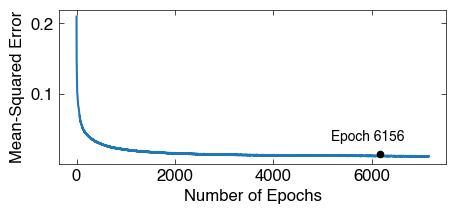

In [114]:
# plot training history
# fig = plt.figure(figsize = (6,4))
NNdfread = pd.read_excel("NN_history.xlsx")
fig = graph_setup(5,2)
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(111)

ax.plot(NNdfread['train'],label='Train')
# ax.plot(NNdfread['validation'],dashes=(10,30),label='validation')
y = list(NNdfread['validation'])
x = range(1,len(y)+1)
ymin = np.min(NNdfread['validation'])
yminindex = y.index(ymin)
xmin = x[yminindex]
# ymin = history.history['val_loss'][-1]
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Mean-Squared Error')
# plt.title("# Epochs vs. Mean Squared Error",fontweight='bold')
text = ('Epoch %d' % (xmin))
ax.scatter(xmin,ymin, c='black',zorder=10,s=20)
ax.annotate(text,
             xy=(xmin,ymin), # this is the point to label
             textcoords="offset points",
             xytext = (-35,10), 
             fontsize=10) # right or center

set_widths(ax)
# leg = ax.legend(fontsize=8,fancybox=False)
# leg_setup(leg)
save_graph('NNhistory.eps',fig,'eps')
plt.show()

In [115]:
estimator.model.save("Reverse_NN_9_23.h5")

### Grid Searching

In [107]:
# grid search # neurons
estimator_n = KerasRegressor(build_fn=Net, epochs=5313, batch_size=32, verbose=0)
# neurons = list(np.arange(0,50,5))
neurons = [20,25,30,35,40,45,50]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=estimator_n, 
                    scoring='neg_mean_squared_error', 
                    param_grid=param_grid,  
                    verbose=1,
                    n_jobs=-1,
                    cv=2)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means3 = grid_result.cv_results_['mean_test_score']
stds3 = grid_result.cv_results_['std_test_score']
params3 = grid_result.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 7 candidates, totalling 14 fits
Best: -0.018987 using {'neurons': 45}
-0.025778 (0.001133) with: {'neurons': 20}
-0.024396 (0.000856) with: {'neurons': 25}
-0.022525 (0.001214) with: {'neurons': 30}
-0.020395 (0.000238) with: {'neurons': 35}
-0.021548 (0.001245) with: {'neurons': 40}
-0.018987 (0.001081) with: {'neurons': 45}
-0.019436 (0.000125) with: {'neurons': 50}


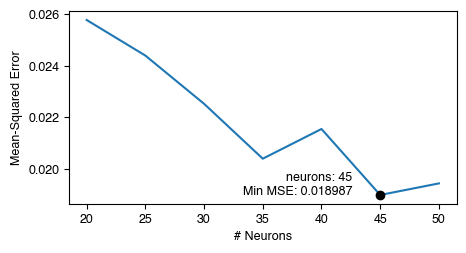

In [108]:
# Graph Neurons

x = [data['neurons'] for data in params3]
y = means3*-1
ymin = np.min(y)
yminindex = y.tolist().index(ymin)
xmin = x[yminindex]
fig = graph_setup(5,2.5)
ax = fig.add_subplot(111)
ax.plot(x,y)
ax.set_xlabel('# Neurons')
ax.set_ylabel('Mean-Squared Error')
# plt.title('# Neurons vs. Mean-Squared Error',fontweight='bold')
text = ('neurons: %d\nMin MSE: %f' % (xmin,ymin))
ax.scatter(xmin,ymin,c='k',zorder=10)
ax.annotate(text,
             (xmin,ymin), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(-20,0), # distance from text to points (x,y)
             ha='right') # horizontal alignment can be left, right or center
save_graph('grid_neurons.eps',fig,'eps')
plt.show()

In [109]:
# grid search activation functions
estimator_n = KerasRegressor(build_fn=Net, epochs=5000, batch_size=32, verbose=0)
hidden_act = ["sigmoid","relu","tanh","softmax"]
final_act = ["sigmoid","relu","tanh","linear"]

param_grid = dict(hidden_act=hidden_act, final_act=final_act)
grid = GridSearchCV(estimator=estimator_n, 
                    scoring='neg_mean_squared_error', 
                    param_grid=param_grid, 
                    verbose=1, 
                    n_jobs=-1,
                    cv=3)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best: -0.016810 using {'final_act': 'tanh', 'hidden_act': 'sigmoid'}
-0.016894 (0.000558) with: {'final_act': 'sigmoid', 'hidden_act': 'sigmoid'}
-0.018949 (0.001553) with: {'final_act': 'sigmoid', 'hidden_act': 'relu'}
-0.019408 (0.001238) with: {'final_act': 'sigmoid', 'hidden_act': 'tanh'}
-0.023146 (0.001154) with: {'final_act': 'sigmoid', 'hidden_act': 'softmax'}
-0.017450 (0.001620) with: {'final_act': 'relu', 'hidden_act': 'sigmoid'}
-0.019297 (0.000719) with: {'final_act': 'relu', 'hidden_act': 'relu'}
-0.018696 (0.001757) with: {'final_act': 'relu', 'hidden_act': 'tanh'}
-0.020798 (0.000853) with: {'final_act': 'relu', 'hidden_act': 'softmax'}
-0.016810 (0.001064) with: {'final_act': 'tanh', 'hidden_act': 'sigmoid'}
-0.020162 (0.004122) with: {'final_act': 'tanh', 'hidden_act': 'relu'}
-0.019104 (0.001003) with: {'final_act': 'tanh', 'hidden_act': 'tanh'}
-0.022073 (0.000446) with: {'final_act': 'tanh', 'hidden_act':

# Applying NN

In [149]:
# open saved model
from keras.models import load_model

loaded = KerasRegressor(build_fn=Net)
loaded.model = load_model("Reverse_NN_9_23.h5")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


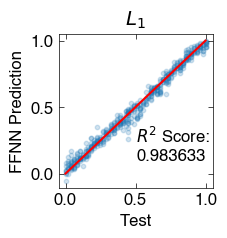

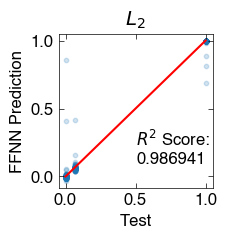

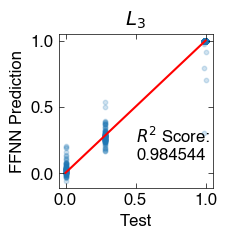

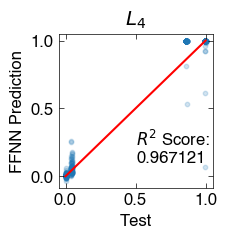

R^2 Score: 0.8989566666275847


In [150]:
y_pred = loaded.model.predict(X_test)
fig0 = graph_setup(2,2)
fig1 = graph_setup(2,2)
fig2 = graph_setup(2,2)
fig3 = graph_setup(2,2)

plt.rcParams.update({'font.size': 12})
x = np.linspace(-0,1,2)
y = x

# fig = plt.figure(figsize=(12,12))
ax0 = fig0.add_subplot(111)
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax3 = fig3.add_subplot(111)
axes = [ax0,ax1,ax2,ax3]
Ls = ['$L_1$','$L_2$','$L_3$','$L_4$']

for n in range(len(axes)):
    set_widths(axes[n])
    axes[n].scatter(y_test[:,n],y_pred[:,n],s=10,alpha=0.2)
    axes[n].plot(x,y,'r')
    axes[n].set_ylabel('FFNN Prediction')
    axes[n].set_xlabel('Test')
    titletxt = Ls[n]
    axes[n].set_title(titletxt,fontweight='bold')
    Rtext = '$R^2$ Score:\n%f' % (r2_score(y_pred[:,n],y_test[:,n]))
    axes[n].annotate(Rtext,
             xy=(.5,0.1), # this is the point to label
             textcoords="offset points",
             fontsize=12) # right or center
    axes[n].set_box_aspect(1)
plt.show()
print('R^2 Score:',r2_score(y_test,y_pred))
save_graph('L1_R2.tiff',fig0,'tiff')
save_graph('L2_R2.tiff',fig1,'tiff')
save_graph('L3_R2.tiff',fig2,'tiff')
save_graph('L4_R2.tiff',fig3,'tiff')
# save_graph('L5_R2.tiff',fig4,'tiff')

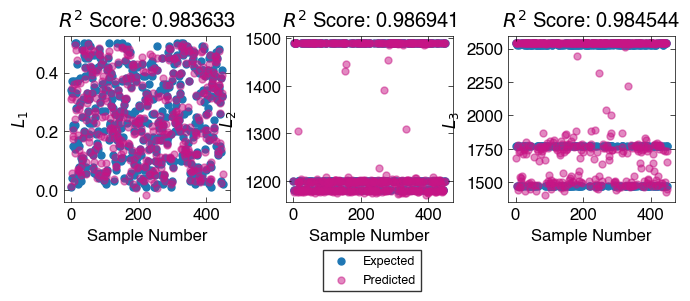

R^2 Score: 0.8989566662380776


In [151]:
y_pred = loaded.model.predict(X_test)
# print(y_pred)
fig0 = graph_setup(6.5*1.25,6.5/3)
# fig1 = graph_setup(6.5/3,6.5/3)
# fig2 = graph_setup(6.5/3,6.5/3)
plt.rcParams.update({'font.size': 12})
y_test_ = X_scaler.inverse_transform(y_test)
y_pred_ = X_scaler.inverse_transform(y_pred)

# fig = plt.figure(figsize=(12,12))
ax0 = fig0.add_subplot(131)
ax1 = fig0.add_subplot(132)
ax2 = fig0.add_subplot(133)
set_widths(ax0)
set_widths(ax1)
set_widths(ax2)
size = 25
ax0.scatter(range(len(y_test_[:,0])),y_test_[:,0],s=size,label='Expected')
ax0.scatter(range(len(y_pred_[:,0])),y_pred_[:,0],s=size,alpha=0.5,color='mediumvioletred',label='Predicted')
ax1.scatter(range(len(y_test_[:,1])),y_test_[:,1],s=size,label='Expected')
ax1.scatter(range(len(y_pred_[:,1])),y_pred_[:,1],s=size,alpha=0.5,color='mediumvioletred',label='Predicted')
ax2.scatter(range(len(y_test_[:,2])),y_test_[:,2],s=size,label='Expected')
ax2.scatter(range(len(y_pred_[:,2])),y_pred_[:,2],s=size,alpha=0.5,color='mediumvioletred',label='Predicted')
ax0.set_box_aspect(1)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)



ax0.set_ylabel('$L_1$')
ax0.set_xlabel('Sample Number')
R0text = '$R^2$ Score: %f' % (r2_score(y_pred_[:,0],y_test_[:,0]))
ax0.set_title(R0text,fontweight='bold')

ax1.set_ylabel('$L_2$')
ax1.set_xlabel('Sample Number')
R1text = '$R^2$ Score: %f' % (r2_score(y_pred_[:,1],y_test_[:,1]))
ax1.set_title(R1text,fontweight='bold')
# ax1.legend('Expected','Model')

ax2.set_ylabel('$L_3$')
ax2.set_xlabel('Sample Number')
titletxt = ('$L_3$')
R2text = '$R^2$ Score: %f' % (r2_score(y_pred[:,2],y_test[:,2]))

ax2.set_title(R2text,fontweight='bold')
leg0 = ax1.legend(bbox_to_anchor=(.85, -.25),fontsize=9,fancybox=False)
leg0.get_frame().set_edgecolor('k')
save_graph('R2_score.pdf',fig0,'pdf')
# save_graph('L2_R2.pdf',fig1)
# save_graph('L3_R2.pdf',fig2)

plt.show()
print('R^2 Score:',r2_score(y_test_,y_pred_))

## Testing on existing

### Define functions

#### Helper functions

In [166]:
out_lab = ['Matrix Density (kg/m^3)',
           'Matrix Elastic Modulus (MPa)', 
           "Matrix Poisson's Ratio",
           'Matrix Yield Strength (MPa)',
           'Matrix Hardening Parameter (MPa)',
           'Temperature (K)',
           'Filler Density (kg/m^3)',
           'Filler Elastic Modulus 1 (MPa)',
           'Filler Elastic Modulus 2 (MPa)',
           'Filler Elastic Modulus 3 (MPa)',
           'Filler Poisson 1',
           'Filler Poisson 2',
           'Filler Poisson 3',
           'Filler Shear 1 (MPa)',
           'Filler Shear 2 (MPa)',
           'Filler Shear 3 (MPa)']
in_lab = ['Composite Elastic Modulus (MPa)',
          'Composite Yield Strength (MPa)',
          'Composite Resilience (MJ/m^3)',
          'Composite Toughness (MJ/m^3)'] 

def find_mat_prop(mfvt):
    mat,fill,vf,temp = mfvt
    data = df.loc[(df['Matrix Material'] == mat) &
                  (df['Filler Material'] == fill) & 
                  (df['Volume Fraction'] == vf) & 
                  (df['Temperature (K)'] == temp)]
    return data

def find_mat_names(MPD_array):
    labels = ['PAI/Carbon','PAI/E-Glass','PAI/Kevlar','PAI/S-Glass',
          'PC/Carbon','PC/E-Glass','PC/Kevlar','PC/S-Glass',
          'PMMA/Carbon','PMMA/E-Glass','PMMA/Kevlar','PMMA/S-Glass']
    MPD_all = MPD_pca.transform(MPD_scaler.transform(X_df.drop(columns=dropping)))

    for i,val in enumerate(MPD_all):
        matrix = datadf.iloc[i,[1]].tolist()
        filler = datadf.iloc[i,[2]].tolist()
        material = matrix[0] + "/" + filler[0]
        for n, lab in enumerate(labels):
            if lab == material:
                break
        if list(MPD_array) == list([MPD_all[i,0],MPD_all[i,1],MPD_all[i,2],MPD_all[i,3]]):
            c_mat = matrix[0]
            c_fill = filler[0]
            break
#     print(c_mat,' ',c_fill)
    return c_mat,c_fill

def denstovf(mat,fill,dens):
    matdens = {'PAI':1490,
               'PC':1200,
               'PMMA':1180}
    filldens = {'Carbon':1770,
                'E-Glass':2490,
                'Kevlar':1470,
                'S-Glass':2490}
    vf = (dens-matdens[mat])/(filldens[fill]-matdens[mat])
    return vf

def vftodens(mat,fill,vf):
    matdens = {'PAI':1490,
               'PC':1200,
               'PMMA':1180}
    filldens = {'Carbon':1770,
                'E-Glass':2490,
                'Kevlar':1470,
                'S-Glass':2490}
    if mat in matdens:
        matrix = matdens[mat]
    else:
        matrix = mat;
    if fill in filldens:
        filler = filldens[fill]
    else:
        filler = fill
        
    return matrix*(1-vf) + filler*vf

def find_closest(array):
    
    MPD_all = MPD_pca.transform(MPD_scaler.transform(X_df.drop(columns=dropping)))
    MPD_unique = [i for n, i in enumerate(MPD_all) if i not in MPD_all[:n]]

    for ind, arr in enumerate(MPD_unique):
#         dist = (arr[0]-array[0])**2 + (arr[1]-array[1])**2 + (arr[2]-array[2])**2 + (arr[3]-array[3])**2
        dist = sum([(arr[i]-array[i])**2 for i in range(len(arr))])
        if ind == 0:
            c_array = arr
            c_dist = dist
        elif dist < c_dist:
            c_array = arr
            c_dist = dist
    # returns closest array and closest distance
    return c_array, c_dist

def find_closest2(array,dataset):
    
    MPD_all = (MPD_pca.transform(MPD_scaler.transform(dataset.iloc[:,np.arange(3,16)])))
    MPD_unique = [i for n, i in enumerate(MPD_all) if i not in MPD_all[:n]]
    

    for ind, arr in enumerate(MPD_unique):
#         dist = (arr[0]-array[0])**2 + (arr[1]-array[1])**2 + (arr[2]-array[2])**2 + (arr[3]-array[3])**2
        dist = sum([(arr[i]-array[i])**2 for i in range(len(arr))])
        if ind == 0:
            c_array = arr
            c_dist = dist
        elif dist < c_dist:
            c_array = arr
            c_dist = dist
    # returns closest array and closest distance
    return c_array

def graph_on_LMPS(mat_props,closest):
    
    markers = ['_','$O$','o','.','^','X','P','*','d','|','1','+']
    labels = ['PAI/Carbon','PAI/E-Glass','PAI/S-Glass','PAI/Kevlar',
              'PC/Carbon','PC/E-Glass','PC/Kevlar','PC/S-Glass',
              'PMMA/Carbon','PMMA/E-Glass','PMMA/Kevlar','PMMA/S-Glass']
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray',
             'tab:olive','tab:cyan','purple','b']
    fig = plt.figure(figsize=(12,6))
    ax0 = fig.add_subplot(121,projection='3d')
    ax1 = fig.add_subplot(122)
    proj2d_0 = 0
    proj2d_1 = 1
    MPD_all = MPD_pca.transform(MPD_scaler.transform(X_df.drop(columns=["Volume Fraction","Matrix Material","Filler Material"])))

    for i,val in enumerate(MPD_all):
        matrix = datadf.iloc[i,[1]].tolist()
        filler = datadf.iloc[i,[2]].tolist()
        material = matrix[0] + "/" + filler[0]
        for n, lab in enumerate(labels):
            if lab == material:
                break
        ax0.scatter(MPD_all[i,0],MPD_all[i,1],MPD_all[i,2],color=colors[n],marker=markers[n])
        ax1.scatter(MPD_all[i,proj2d_0],MPD_all[i,proj2d_1],color=colors[n],marker=markers[n]) 
        if list(closest) == list([MPD_all[i,0],MPD_all[i,1],MPD_all[i,2]]):
            c_mat = matrix[0]
            c_fill = filler[0]

    ax0.view_init(elev=30, azim=30)
    ax0.set_xlabel('L1')
    ax0.set_ylabel('L2')
    ax0.set_zlabel('L3')
    ax1.set_xlabel('L'+str(proj2d_0+1))
    ax1.set_ylabel('L'+str(proj2d_1+1))
    ax0.set_title('Latent Material Property Space')
    ax1.set_title('Latent Material Property Space')

    [ax1.scatter([], [], color=colors[i], marker=markers[i], label=labels[i]) for i in range(len(labels))]
    
    test_label = "Test Material\n(%.2f, %.2f, %.2f)" % (mat_props[0,0],mat_props[0,1],mat_props[0,2])
    ax0.scatter(mat_props[0,0],mat_props[0,1],mat_props[0,2],
                marker='s',color='black',label=test_label)
    ax1.scatter(mat_props[0,proj2d_0],mat_props[0,proj2d_1],
                marker='s',color='black',label=test_label,)
    
    ax0.scatter(closest[0],closest[1],closest[2],marker='x',color='black',label='closest')
    ax1.scatter(closest[proj2d_0],closest[proj2d_1],marker='x',color='black',label='closest')
    

    
    ax1.legend(bbox_to_anchor=(1, 1),markerscale=2.)
        
    plt.show()
    return c_mat, c_fill

def rand_in_range(feat):
    from numpy import random
    return random.rand()*(max(feat)-min(feat))+min(feat)

def rand_props():
    E = datadf["Composite Elastic Modulus (MPa)"].values
    YS = datadf["Composite Yield Strength (MPa)"].values
    R = datadf["Composite Resilience (MJ/m^3)"].values
    T = datadf["Composite Toughness (MJ/m^3)"].values
    density = df["Density (kg/m^3)"].values
    print(min(E),max(E))
    print(min(YS),max(YS))
    print(min(R),max(R))
    print(min(T),max(T))
    print(min(density),max(density))
    Erand = rand_in_range(E)
    YSrand = rand_in_range(YS)
    Rrand = rand_in_range(R)
    Trand = rand_in_range(T)
    densrand = rand_in_range(density)
    return [densrand, Erand,YSrand,Rrand,Trand]

def find_close_mat_performance(mat,dataset):
    # mat is a (1 x M) array, where M is the number of features
    # dataset is a (N x M) array, where N is the number of samples
    dataset = np.array(dataset)
    scale = StandardScaler()
    scale.fit(dataset[:,-5:])
    for n in range(np.shape(dataset)[0]):
        dataset_s = scale.transform(np.array(dataset[n][-5:]).reshape(1, -1)).flatten()
        mat_s = scale.transform(np.array(mat[-5:]).reshape(1, -1)).flatten()
        distance = sum(np.square(np.subtract(mat_s,dataset_s)))**(1/2)
        if n == 0:
            closest_distance = distance
            closest_mat = dataset[n]
        else:
            if distance < closest_distance:
                closest_distance = distance
                closest_mat = dataset[n]
    avg_perc_err = 100 * sum(abs(mat_s-dataset_s)/mat_s)/len(mat_s)
    print(len(mat_s))
    return closest_mat, avg_perc_err

def find_close_mat_properties(mat,all_dataset,mat_dataset):
    # mat is a (1 x M) array, where M is the number of features
    # dataset is a (N x M) array, where N is the number of samples
    all_dataset = np.array(all_dataset)
    mat_dataset = np.array(mat_dataset)
    scale = MinMaxScaler()
    propindex = np.hstack([0,np.arange(3,19)])
    scale.fit(all_dataset[:,propindex])
    mat_s = scale.transform(np.array(mat[:-5]).reshape(1, -1)).flatten()
    for n in range(np.shape(mat_dataset)[0]):
        dataset_s = scale.transform(np.array(mat_dataset[n][propindex]).reshape(1, -1)).flatten()
#         print(dataset_s)
        distance = sum((np.subtract(mat_s,dataset_s))**2)**(1/2)
        if n == 0:
            closest_distance = distance
            closest_mat = mat_dataset[n]
#             print(closest_mat)
            closest_dset_s = dataset_s
        else:
            if distance < closest_distance:
                closest_distance = distance
                closest_mat = mat_dataset[n]
                closest_dset_s = dataset_s
#     print(closest_dset_s)

#     avg_perc_err = 100 * sum(abs(mat_s-closest_dset_s)/abs(mat_s))/len(mat_s)
    return closest_mat, closest_distance

#### Used function

In [167]:
def return_feats(dEYRT,graph,*args):
    # EYRT is a list of the mech props
    mechs = np.array([dEYRT])
    mechs_t = y_scaler.transform(mechs)
    y = mechs_t.reshape(1,-1)
    mat_props = loaded.model.predict(y)
    unscaled_props = X_scaler.inverse_transform(mat_props)
    print(unscaled_props)
    vf = unscaled_props[0,0:2]
    fill_dense = unscaled_props[0,2]

    print(unscaled_props[0,3::])
    MPDs = MPD_pca.inverse_transform(unscaled_props[0,3::])
    MPDs = MPD_scaler.inverse_transform(MPDs)
    MPDs = np.insert(MPDs,5,fill_dense)
    
    c_array, c_dist = find_closest(X_scaler.inverse_transform(mat_props).flatten())
    
    if graph == 0:
        c_mat, c_fill = find_mat_names(c_array)
    elif graph == 1:
        c_mat, c_fill = graph_on_LMPS(X_scaler.inverse_transform(mat_props),c_array)
#     print(vf)
    print(MPDs)
#     print(np.hstack([[vf],[MPDs],mechs]))
    test_mat_df = pd.DataFrame(np.hstack([[vf],[MPDs],mechs]).T,
                    index=datadf.drop(columns=["Matrix Material","Filler Material"]).columns,
                    columns=['values'])
    return test_mat_df, c_dist

def return_mats(dEYRT):
    # EYRT is a list of the mech props
    mechs = np.array([dEYRT])
    mechs_t = y_scaler.transform(mechs)
    y = mechs_t.reshape(1,-1)
    mat_props = loaded.model.predict(y)
    MPDs = MPD_scaler.inverse_transform(MPD_pca.inverse_transform(X_scaler.inverse_transform(mat_props)))
    c_array, c_dist = find_closest(X_scaler.inverse_transform(mat_props).flatten())
    c_mat, c_fill = find_mat_names(c_array)
    return c_mat,c_fill,c_dist

def return_dEYRT(mat_props):
    prop = datadf[(datadf['Volume Fraction'] == mat_props[0]) & 
                  (datadf['Matrix Material'] == mat_props[1]) &
                  (datadf['Filler Material'] == mat_props[2]) & 
                  (datadf['Temperature (K)'] == mat_props[17])]
    
    dEYRT = (prop.values.tolist())[0]
#     print(prop.values)
    return dEYRT[-5:]
    
def avg_mat(mfvt1,mfvt2):
    # takes in two arrays for the two materials that consist of (matrix material, filler material, volume fraction, temperature)
    mat1 = find_mat_prop(mfvt1).to_numpy().flatten()
    loc = [isinstance(mat1[i],(float,int)) for i in range(len(mat1))]
    mat1 = mat1[loc]
    mat2 = find_mat_prop(mfvt2).to_numpy().flatten()
    mat2 = mat2[loc]    
    avg = (mat1+mat2)/2
    return avg

def find_close_mat_spec(mat,matrix,filler,method):
    if matrix == 0:
        mat_dataset = df.values.tolist()
    else:
        mat_dataset = df.loc[(df['Matrix Material'] == matrix) &
                             (df['Filler Material'] == filler)].values.tolist()
        
    mat = np.array(mat.T.values.tolist()[0])
    if method == 'performance':
        closest_mat,avg_perc_err = find_close_mat_performance(mat,df,mat_dataset)
    elif method == 'properties':
        closest_mat,avg_perc_err = find_close_mat_properties(mat,df,mat_dataset)
    mat_df = pd.DataFrame(closest_mat,
                          index=datadf.columns,
                          columns=['values'])
    print(avg_perc_err,'%')
    return mat_df

def convert_to_upper(m):
    s = m[0].upper() + m[1::]
    return s

## Generate Combinations

In [128]:
pd.set_option('display.max_columns',None)
test = avg_mat(['PMMA','Carbon',0.35,298],['PMMA','Kevlar',0.35,298])
test_df = pd.DataFrame(test,index=datadf.drop(columns=["Matrix Material","Filler Material"]).columns).T
test_df

,Volume Fraction,Matrix Density (kg/m^3),Matrix Elastic Modulus (MPa),Matrix Poisson's Ratio,Matrix Yield Strength (MPa),Matrix Hardening Parameter,Temperature (K),Filler Density (kg/m^3),Filler Elastic Modulus 1,Filler Elastic Modulus 2,Filler Elastic Modulus 3,Filler Poisson 1,Filler Poisson 2,Filler Poisson 3,Filler Shear 1,Filler Shear 2,Filler Shear 3,Density (kg/m^3),Composite Elastic Modulus (MPa),Composite Yield Strength (MPa),Composite Resilience (MJ/m^3),Composite Toughness (MJ/m^3)
0,0.35,1180.0,2448.770492,0.36,106.557377,0.444529,298.0,1620.0,185000.0,9100.0,9100.0,0.275,0.275,0.3,5950.0,5950.0,3050.0,1334.0,4942.932333,122.921966,1.698359,4.672679


In [139]:
test1 = avg_mat(['PMMA','Carbon',0.35,298],['PMMA','E-Glass',0.35,298])
test2 = avg_mat(['PMMA','Carbon',0.35,298],['PMMA','Carbon',0.35,333])
test3 = avg_mat(['PMMA','Carbon',0.35,298],['PAI','Carbon',0.35,298])
test_df = pd.DataFrame(np.vstack([test1,test2,test3]).T,index=datadf.drop(columns=["Matrix Material","Filler Material"]).columns).T
test_df

,Volume Fraction,Matrix Density (kg/m^3),Matrix Elastic Modulus (MPa),Matrix Poisson's Ratio,Matrix Yield Strength (MPa),Matrix Hardening Parameter,Temperature (K),Filler Density (kg/m^3),Filler Elastic Modulus 1,Filler Elastic Modulus 2,Filler Elastic Modulus 3,Filler Poisson 1,Filler Poisson 2,Filler Poisson 3,Filler Shear 1,Filler Shear 2,Filler Shear 3,Density (kg/m^3),Composite Elastic Modulus (MPa),Composite Yield Strength (MPa),Composite Resilience (MJ/m^3),Composite Toughness (MJ/m^3)
0,0.35,1180.0,2448.770492,0.36,106.557377,0.444529,298.0,2155.0,147500.0,44500.0,44500.0,0.2,0.2,0.235,19500.0,19500.0,17300.0,1521.25,5061.461361,127.090674,1.765147,4.870887
1,0.35,1180.0,2050.845287,0.36,93.237705,0.395329,315.5,1770.0,220000.0,14000.0,14000.0,0.2,0.2,0.25,9000.0,9000.0,4600.0,1386.5,4271.685351,111.337638,1.608835,4.400069
2,0.35,1335.0,2495.571686,0.37,106.557377,0.444529,298.0,1770.0,220000.0,14000.0,14000.0,0.2,0.2,0.25,9000.0,9000.0,4600.0,1487.25,5220.102889,126.177383,1.695202,4.704867


In [150]:
print(test_df.at[0,'Matrix Density (kg/m^3)'])
dEYRT1 = [vftodens(1180,2155,0.35), 5237.3139, 117.861025, 1.527444734323, 3.174140795]
dEYRT2 = [vftodens(1180,1770,0.35), 4352.961578947368, 102.181245000000, 1.375820397040, 2.745400885000]
dEYRT3 = [vftodens(1335,1770,0.35), 5305.28444, 115.2878050, 1.439595842354, 3.107731125]
matfeat1, dist1 = return_feats(dEYRT1,0)
matfeat2, dist2 = return_feats(dEYRT2,0)
matfeat3, dist3 = return_feats(dEYRT3,0)

pd.DataFrame(np.hstack([matfeat1,matfeat2,matfeat3]),index=datadf.drop(columns=["Matrix Material","Filler Material"]).columns).T

1180.0
[[ 4.4896108e-01  1.4900000e+03  1.7728350e+03 -2.2727764e+00
  -1.7456025e+00 -7.9345867e-02  1.3464935e+00]]
[-2.2727764  -1.7456025  -0.07934587  1.3464935 ]
[1.83966383e+03 3.80723347e-01 8.58216946e+01 3.53529720e-01
 3.22324658e+02 1.77283496e+03 1.92122207e+05 1.25133115e+04
 1.25133115e+04 1.99143750e-01 1.99143750e-01 2.40197779e-01
 7.17545280e+03 7.17545280e+03 3.76030472e+03]
[[ 4.9973592e-01  1.2055219e+03  1.4812699e+03 -2.4380307e+00
   1.2422658e+00 -1.4163114e+00  2.2925401e-01]]
[-2.4380307  1.2422658 -1.4163114  0.229254 ]
[1.62715632e+03 3.71959762e-01 6.93636259e+01 3.25283460e-01
 3.32896297e+02 1.48126990e+03 1.73433329e+05 6.58669202e+03
 6.58669202e+03 3.38596435e-01 3.38596435e-01 3.48474763e-01
 4.84428529e+03 4.84428529e+03 2.56744857e+03]
[[ 4.7479638e-01  1.4899988e+03  1.7332236e+03 -2.3491945e+00
  -1.5034645e+00 -2.3530784e-01  1.3464868e+00]]
[-2.3491945  -1.5034645  -0.23530784  1.3464868 ]
[1.81115771e+03 3.80746029e-01 8.26793338e+01 3.486704

,Volume Fraction,Matrix Density (kg/m^3),Matrix Elastic Modulus (MPa),Matrix Poisson's Ratio,Matrix Yield Strength (MPa),Matrix Hardening Parameter,Temperature (K),Filler Density (kg/m^3),Filler Elastic Modulus 1,Filler Elastic Modulus 2,Filler Elastic Modulus 3,Filler Poisson 1,Filler Poisson 2,Filler Poisson 3,Filler Shear 1,Filler Shear 2,Filler Shear 3,Density (kg/m^3),Composite Elastic Modulus (MPa),Composite Yield Strength (MPa),Composite Resilience (MJ/m^3),Composite Toughness (MJ/m^3)
0,0.448961,1490.000000,1839.663826,0.380723,85.821695,0.353530,322.324658,1772.834961,192122.207244,12513.311495,12513.311495,0.199144,0.199144,0.240198,7175.452799,7175.452799,3760.304722,1521.25,5237.313900,117.861025,1.527445,3.174141
1,0.499736,1205.521851,1627.156319,0.371960,69.363626,0.325283,332.896297,1481.269897,173433.329131,6586.692022,6586.692022,0.338596,0.338596,0.348475,4844.285292,4844.285292,2567.448571,1386.50,4352.961579,102.181245,1.375820,2.745401
2,0.474796,1489.998779,1811.157715,0.380746,82.679334,0.348670,324.567489,1733.223633,191880.681984,11080.934378,11080.934378,0.210807,0.210807,0.249432,6620.383540,6620.383540,3264.415845,1487.25,5305.284440,115.287805,1.439596,3.107731


## Comparing

### Find Similar Materials

In [ ]:
epoxycarbonperf = find_close_mat_spec(mat1feat,'epoxy','carbon','properties').T
pmmacarbonperf = find_close_mat_spec(mat1feat,'PMMA','carbon','properties').T
petcarbonperf = find_close_mat_spec(mat1feat,'PET','carbon','properties').T
epoxyglassperf = find_close_mat_spec(mat1feat,'epoxy','glass','properties').T
epoxykevlarperf = find_close_mat_spec(mat1feat,'epoxy','kevlar','properties').T

pd.concat([epoxycarbonperf,pmmacarbonperf,petcarbonperf,epoxyglassperf,epoxykevlarperf])

In [ ]:
def graph_close_mats(arr,filename):
    fig = graph_setup(8.5,2)
    axD = subplot(151)
    axE = subplot(152)
    axY = subplot(153)
    axR = subplot(154)
    axT = subplot(155)
    axes = [axD,axE,axY,axR,axT]
    replace_dict = {"PET":"PET", "epoxy":"Epoxy","PMMA":"PMMA",
                    "carbon":"Carbon","glass":"Glass","kevlar":"Kevlar"}
#     mat_ticks = ["SCA","Epoxy-Carbon","PMMA-Carbon","PET-Carbon","Epoxy-Glass","Epoxy-Kevlar"]
    mat_ticks = ["SCA"]
    for a in arr[1:]:
        matrixname = replace_dict[a["Matrix Material"].values[0]]
        fillername = replace_dict[a["Filler Material"].values[0]]
        tickname = "{}-{}".format(matrixname,fillername)
        mat_ticks.append(tickname)
#     print(mat_ticks)
    outlabels = ["Composite Density (kg/m^3)","Composite Elastic Modulus (MPa)",
                            "Composite Yield Strength (MPa)","Composite Resilience (MJ/m^3)",
                            "Composite Toughness (MJ/m^3)"]
    outlabels_edit = ["Composite Density $(kg/m^3)$","Composite Elastic Modulus $(MPa)$",
                            "Composite Yield Strength $(MPa)$","Composite Resilience $(MJ/m^3)$",
                            "Composite Toughness $(MJ/m^3)$"]
    def_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_array = def_colors[0:len(mat_ticks)]
    # setup axes
    SCA_out = pd.DataFrame(arr[0],outlabels).T
    all_perf = [SCA_out,*arr[1:]]
    all_out = {outlabels[0]:[float(x[outlabels[0]].values[0]) for x in all_perf],
               outlabels[1]:[float(x[outlabels[1]].values[0]) for x in all_perf],
               outlabels[2]:[float(x[outlabels[2]].values[0]) for x in all_perf],
               outlabels[3]:[float(x[outlabels[3]].values[0]) for x in all_perf],
               outlabels[4]:[float(x[outlabels[4]].values[0]) for x in all_perf]}
    for a in range(len(axes)):
        axes[a].set_ylabel(outlabels_edit[a])
        axes[a].spines['right'].set_visible(False)
        axes[a].spines['top'].set_visible(False)
        axes[a].set_xticklabels(mat_ticks,rotation=45,horizontalalignment='right')
        for b in range(len(mat_ticks)): 
            axes[a].bar(mat_ticks[b],all_out[outlabels[a]][b],color=color_array[b],width=1,label=mat_ticks[b])
        axes[a].tick_params(labelbottom=False)
    handles, labs = axD.get_legend_handles_labels()
    figleg = fig.legend(handles,mat_ticks,ncol=5,loc='lower center',fancybox=False,bbox_to_anchor=(.52,-.2))
    leg_setup(figleg)
#     for l in range(len(figleg.legendHandles)):
#         figleg.legendHandles[l].set_color(color_array[l])
    plt.tight_layout()
#     save_graph(filename,fig,'eps')
    plt.show()
    

In [ ]:
def closest_mat_graphs(dEYRT,matfeat,filename):
    matrices = ['epoxy','PMMA','PET']
    fillers = ['carbon','glass','kevlar']

    mat1closests = [dEYRT]
    for m in range(len(matrices)):
        for f in range(len(fillers)):
            match_material = find_close_mat_spec(matfeat,matrices[m],fillers[f],'properties').T
            print(match_material[['Matrix Material','Filler Material','Volume Fraction','Temperature (K)']])
            mat1closests.append(match_material)
    graph_close_mats(mat1closests,filename)
    print(dEYRT)
    return pd.concat(mat1closests[1:])

In [ ]:
closest_mat_graphs(dEYRT2,mat1feat,'MAT1_closest2.eps')
#                                                 [['Composite Density (kg/m^3)',
#                                                'Composite Elastic Modulus (MPa)',
#                                                'Composite Yield Strength (MPa)',
#                                                'Composite Resilience (MJ/m^3)',
#                                                'Composite Toughness (MJ/m^3)']]

In [ ]:
closest_mat_graphs(dEYRT3,mat2feat,'MAT2_closest.eps')[['Composite Density (kg/m^3)',
                                               'Composite Elastic Modulus (MPa)',
                                               'Composite Yield Strength (MPa)',
                                               'Composite Resilience (MJ/m^3)',
                                               'Composite Toughness (MJ/m^3)']]

In [ ]:
mat1close = find_close_mat_spec(mat1feat,0,0,'properties').T
mat2close = find_close_mat_spec(mat2feat,0,0,'properties').T
mat3close = find_close_mat_spec(mat3feat,0,0,'properties').T
contrclose = find_close_mat_spec(controlfeat,0,0,'properties').T

pd.concat([mat1close,mat2close,mat3close,contrclose])

In [171]:
dEYRT = [1325.0, 6833.473571, 123.162718, 1.293546, 3.859988]
matfeat, dist = return_feats(dEYRT,0)
matfeat
# find_close_mat_spec(matfeat,0,'carbon','properties')

[[ 4.6854845e-01  1.1797861e+03  1.4822405e+03 -2.4913654e+00
   1.9986157e+00  9.0540312e-02 -1.1834912e+00]]
[-2.4913654   1.9986157   0.09054031 -1.1834912 ]
[2.10257696e+03 3.60734958e-01 1.30532145e+02 4.14963859e-01
 2.87780347e+02 1.48224048e+03 1.71788125e+05 5.46544682e+03
 5.46544682e+03 3.54628091e-01 3.54628091e-01 3.60969144e-01
 4.40229161e+03 4.40229161e+03 2.24348772e+03]


,values
Volume Fraction,0.468548
Matrix Density (kg/m^3),1179.786133
Matrix Elastic Modulus (MPa),2102.576956
Matrix Poisson's Ratio,0.360735
Matrix Yield Strength (MPa),130.532145
Matrix Hardening Parameter,0.414964
Temperature (K),287.780347
Filler Density (kg/m^3),1482.240479
Filler Elastic Modulus 1,171788.124955
Filler Elastic Modulus 2,5465.446822


## Find Best Material

In [ ]:
# 3D plots
matrices = ['PAI','PC','PMMA']
fillers = ['Carbon','E-Glass','Kevlar','S-Glass']
capt = ['a.','b.','c.','d.','e.','f.','g.','h.','i.']

fig0 = graph_setup(12,8)
# fig1 = graph_setup(3,2)
# fig2 = graph_setup(3,2)
# fig3 = graph_setup(3,2)
# fig4 = graph_setup(3,2)
# fig5 = graph_setup(3,2)
# fig6 = graph_setup(3,2)
# fig7 = graph_setup(3,2)
# fig8 = graph_setup(3,2)
# figs = [fig0,fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8]

ax0 = fig0.add_subplot(341,projection = '3d')
ax1 = fig0.add_subplot(342,projection = '3d')
ax2 = fig0.add_subplot(343,projection = '3d')
ax3 = fig0.add_subplot(344,projection = '3d')
ax4 = fig0.add_subplot(345,projection = '3d')
ax5 = fig0.add_subplot(346,projection = '3d')
ax6 = fig0.add_subplot(347,projection = '3d')
ax7 = fig0.add_subplot(348,projection = '3d')
ax8 = fig0.add_subplot(349,projection = '3d')
ax9 = fig0.add_subplot(3,4,10,projection = '3d')
ax10 = fig0.add_subplot(3,4,11,projection = '3d')
ax11 = fig0.add_subplot(3,4,12,projection = '3d')


axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
axislabel = 10
i = 0
best_mats = []
best_ratios = []
for m in range(len(matrices)):
    for f in range(len(fillers)):
        set_widths(axes[i])
        plt.rcParams.update({'font.size': 9})
        mat_data = datadf[(datadf["Matrix Material"] == matrices[m]) &
                          (datadf["Filler Material"] == fillers[f]) & 
                          (datadf["Temperature (K)"] > 290) & (datadf["Temperature (K)"] < 301)]
        x = mat_data["Density (kg/m^3)"]
        y = mat_data["Composite Elastic Modulus (MPa)"]
        z = mat_data["Composite Toughness (MJ/m^3)"]
        vf = mat_data["Volume Fraction"]
        axes[i].set_xlabel('$\\rho_c \, (kg/m^3)$',labelpad=-1,fontsize=axislabel)
        axes[i].set_ylabel('$E_T \, (MPa)$',labelpad=0,fontsize=axislabel)
        axes[i].set_zlabel('$U_{T} \, (MJ/m^3)$',labelpad=-4,fontsize=axislabel)
        axes[i].tick_params(axis='x', labelrotation=45, pad=-6)
        axes[i].tick_params(axis='y', labelrotation=-30, pad=-3)
        axes[i].tick_params(axis='z', pad=-1)
        # title
        titletext = "{}/{}".format(convert_to_upper(matrices[m]),convert_to_upper(fillers[f]))
        axes[i].set_title(titletext,y=0.98,fontsize=12)
#         axes[i].set_title(capt[i],y=-.25,x=.6,fontsize=12)

        im = axes[i].scatter(x,y,z,c=vf,alpha=1,zorder=vf)
        mat_props = mat_data.iloc[:,18::].to_numpy()
#         mat_props = y_minmax_scaler.transform(y_scaler.transform(mat_props))+2
#         print(mat_props)
#         ratios = (mat_props[:,1]*mat_props[:,4] / mat_props[:,0]).tolist()
        ratios = mat_data["Composite Toughness (MJ/m^3)"] * mat_data["Composite Elastic Modulus (MPa)"]/mat_data["Density (kg/m^3)"]
        ratios = ratios.to_list()
        max_ratio = max(ratios)
        best_ratios.append(max_ratio)
        index = ratios.index(max_ratio)
#         print(index)
        best = mat_data.iloc[index,:]
        best_mats.append(best)
        i += 1
        
max_best_ratio = max(best_ratios)
print(best_ratios)
print(max_best_ratio)
best_rat_index = best_ratios.index(max_best_ratio)
print(best_mats[best_rat_index])
plt.tight_layout(pad=5)

cbar = fig0.colorbar(im,ax=axes,shrink=0.75,pad=0.075)
cbar.set_label('Volume Fraction', rotation=90,size=12)
plt.show()
save_graph('dETvf_graphs.eps',fig0,'eps')

In [ ]:
# check
matrices = ['PAI','PC','PMMA']
fillers = ['Carbon','E-Glass','Kevlar','S-Glass']
capt = ['a.','b.','c.','d.','e.','f.','g.','h.','i.']

fig0 = graph_setup(10,10)
# fig1 = graph_setup(3,2)
# fig2 = graph_setup(3,2)
# fig3 = graph_setup(3,2)
# fig4 = graph_setup(3,2)
# fig5 = graph_setup(3,2)
# fig6 = graph_setup(3,2)
# fig7 = graph_setup(3,2)
# fig8 = graph_setup(3,2)
# figs = [fig0,fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8]

ax0 = fig0.add_subplot(341)
ax1 = fig0.add_subplot(342)
ax2 = fig0.add_subplot(343)
ax3 = fig0.add_subplot(344)
ax4 = fig0.add_subplot(345)
ax5 = fig0.add_subplot(346)
ax6 = fig0.add_subplot(347)
ax7 = fig0.add_subplot(348)
ax8 = fig0.add_subplot(349)
ax9 = fig0.add_subplot(3,4,10)
ax10 = fig0.add_subplot(3,4,11)
ax11 = fig0.add_subplot(3,4,12)


axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
axislabel = 10
i = 0
best_mats = []
best_ratios = []
for m in range(len(matrices)):
    for f in range(len(fillers)):
        set_widths(axes[i])
        plt.rcParams.update({'font.size': 9})
        mat_data = datadf[(datadf["Matrix Material"] == matrices[m]) &
                          (datadf["Filler Material"] == fillers[f]) & 
                          (datadf["Temperature (K)"] > 290) & (datadf["Temperature (K)"] < 301)]
#         y = mat_data["Composite Elastic Modulus (MPa)"]
        y = mat_data["Composite Toughness (MJ/m^3)"]
        x = mat_data["Volume Fraction"]

        axes[i].set_xlabel('$U_T$',labelpad=-1,fontsize=axislabel)
        axes[i].set_ylabel('$Volume Fraction$',labelpad=0,fontsize=axislabel)
        # title
        titletext = "{}-{}".format(convert_to_upper(matrices[m]),convert_to_upper(fillers[f]))
        axes[i].set_title(titletext,y=0.98,fontsize=12)
#         axes[i].set_title(capt[i],y=-.25,x=.6,fontsize=12)

        im = axes[i].scatter(x,y,alpha=1)
        mat_props = mat_data.iloc[:,18::].to_numpy()
#         mat_props = y_minmax_scaler.transform(y_scaler.transform(mat_props))+2
#         print(mat_props)
        ratios = (mat_props[:,1]*mat_props[:,4] / mat_props[:,0]).tolist()
#         print(ratios)
        max_ratio = max(ratios)
        best_ratios.append(max_ratio)
        index = ratios.index(max_ratio)
#         print(index)
        best = mat_data.iloc[index,:]
        best_mats.append(best)
        i += 1
        
max_best_ratio = max(best_ratios)
print(best_ratios)
print(max_best_ratio)
best_rat_index = best_ratios.index(max_best_ratio)
print(best_mats[best_rat_index])
# plt.tight_layout(pad=4)

plt.show()

[18.59886153192427, 8.457847775184229, 19.646380204295895, 16.02669588330385, 6.955052243159588, 16.40420568217802, 18.405611570852937, 8.67926723076615, 19.907265760041497, 15.888727885863823, 6.921227029259702, 16.29311086922895, 18.59886153192427, 8.457847775184229, 19.646380204295895, 16.02669588330385, 6.955052243159588, 16.40420568217802, 18.405611570852937, 8.67926723076615, 19.907265760041497, 15.888727885863823, 6.921227029259702, 16.29311086922895]
19.907265760041497
Volume Fraction                            0.5
Matrix Material                           PMMA
Filler Material                         Kevlar
Matrix Density (kg/m^3)                   1180
Matrix Elastic Modulus (MPa)       2448.770492
Matrix Poisson's Ratio                    0.36
Matrix Yield Strength (MPa)         106.557377
Matrix Hardening Parameter            0.444529
Temperature (K)                            298
Filler Density (kg/m^3)                   1470
Filler Elastic Modulus 1                150000
F

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


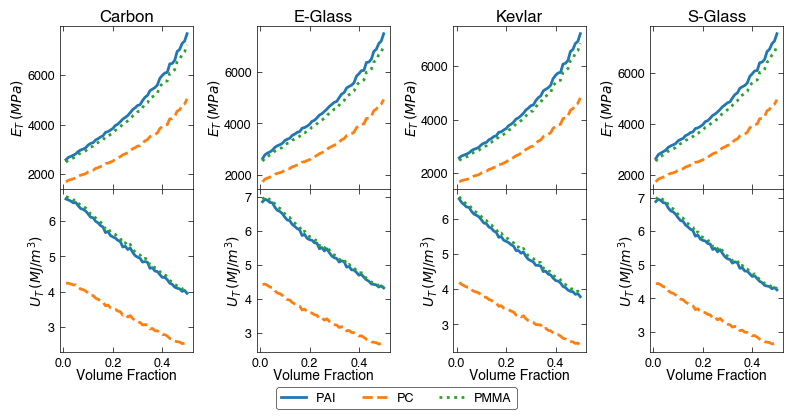

In [84]:
# 2D plots
from matplotlib import gridspec
matrices = ['PAI','PC','PMMA']
fillers = ['Carbon','E-Glass','Kevlar','S-Glass']
capt = ['a.','b.','c.','d.','e.','f.','g.','h.','i.']

fig0 = graph_setup(8,4)
gs = gridspec.GridSpec(2,4, height_ratios=[1, 1]) 

ax0 = fig0.add_subplot(gs[0])
ax1 = fig0.add_subplot(gs[1])
ax2 = fig0.add_subplot(gs[2])
ax3 = fig0.add_subplot(gs[3])
ax4 = fig0.add_subplot(gs[4], sharex = ax0)
ax5 = fig0.add_subplot(gs[5], sharex = ax1)
ax6 = fig0.add_subplot(gs[6], sharex = ax2)
ax7 = fig0.add_subplot(gs[7], sharex = ax3)
perfs = ["Composite Elastic Modulus (MPa)","Composite Toughness (MJ/m^3)"]
perf_labs = ['$E_T \, (MPa)$','$U_{T} \, (MJ/m^3)$']
lines = ['-','--',':']


axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
axislabel = 10
i = 0
best_mats = []
best_ratios = []

for p in range(len(perfs)):
    for f in range(len(fillers)):
        set_widths(axes[i])
        plt.rcParams.update({'font.size': 9})
        for m in range(len(matrices)):
            mat_data = datadf[(datadf["Matrix Material"] == matrices[m]) &
                              (datadf["Filler Material"] == fillers[f]) & 
                              (datadf["Temperature (K)"] == 298)]
            x = mat_data["Volume Fraction"]
            y = mat_data[perfs[p]]
            axes[i].plot(x,y,label=matrices[m],ls=lines[m],lw=2)
            
            # title
            if p == 0:
                axes[i].set_title(fillers[f],y=0.98,fontsize=12)
                axes[i].tick_params('x', labelbottom=False)
            if p == 1:
                axes[i].set_xlabel("Volume Fraction",labelpad=-1,fontsize=axislabel)
            axes[i].set_ylabel(perf_labs[p],labelpad=0,fontsize=axislabel)
            mat_props = mat_data.iloc[:,18::].to_numpy()

            ratios = mat_data["Composite Toughness (MJ/m^3)"] * mat_data["Composite Elastic Modulus (MPa)"]/mat_data["Density (kg/m^3)"]
            ratios = ratios.to_list()
            max_ratio = max(ratios)
            best_ratios.append(max_ratio)
            index = ratios.index(max_ratio)

            best = mat_data.iloc[index,:]
            best_mats.append(best)
        i += 1
        
max_best_ratio = max(best_ratios)
print(best_ratios)
print(max_best_ratio)
best_rat_index = best_ratios.index(max_best_ratio)
print(best_mats[best_rat_index])
plt.tight_layout()

lines_labels = axes[0].get_legend_handles_labels()
lines, labels = lines_labels
leg = fig0.legend(lines,labels, loc='lower center',ncol=3, bbox_to_anchor=(0.5, -0.05))
leg_setup(leg)
plt.subplots_adjust(hspace=.0)
save_graph('dETvf_graphs.eps',fig0,'eps')
plt.show()

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]


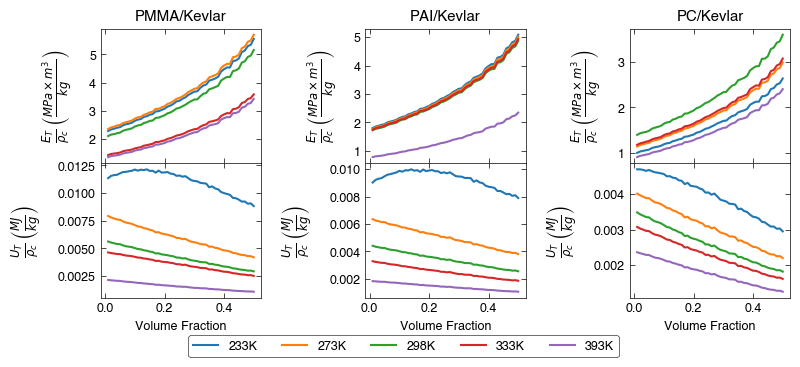

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [147]:
# temperature graphs
fig = graph_setup(8,3.5)
gs = gridspec.GridSpec(2,3, height_ratios=[1, 1]) 

axes = [fig.add_subplot(gs[i]) for i in range(3)]
axes2 = [fig.add_subplot(gs[i], sharex = axes[i-3]) for i in range(3,6)]
axes = np.hstack([axes,axes2])

print(axes)
perfs = ["Composite Elastic Modulus (MPa)","Composite Toughness (MJ/m^3)"]
perf_labs = [r'$\frac{E_T}{\rho_c} \, \left(\frac{MPa \times m^3}{kg}\right)$',
             r'$\frac{U_{T}}{\rho_c} \, \left(\frac{MJ}{kg}\right)$']

for ax in axes:
    set_widths(ax)
mats = ['PMMA','PAI','PC']
fill = 'Kevlar'

n = 0
for p in range(len(perf_labs)):
    for a in range(len(mats)):
        mat = mats[a]
        best_data = datadf[(datadf["Matrix Material"] == mat) &
                           (datadf["Filler Material"] == fill)]
        all_temps = best_data["Temperature (K)"]
        unique_temps = sort(list(set(all_temps)))

        for t in range(len(unique_temps)):
            temp_data = best_data[best_data['Temperature (K)'] == unique_temps[t]]
            x = temp_data["Volume Fraction"]
            y = temp_data[perfs[p]] / temp_data["Density (kg/m^3)"]
            lab = '{}K'.format(unique_temps[t])

            axes[n].plot(x,y,label=lab)
        axes[n].set_xlabel('Volume Fraction')
        axes[n].set_ylabel(perf_labs[p],fontsize = 12,labelpad=10)
        if p == 0:
            title = '{}/{}'.format(mat,fill)
            axes[n].set_title(title)
            axes[n].tick_params('x', labelbottom=False)
        n += 1

    
lines_labels = axes[0].get_legend_handles_labels()

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lines, labels = lines_labels

leg = fig.legend(lines,labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.tight_layout()
leg_setup(leg)
plt.subplots_adjust(hspace=.0)
plt.show()
# name = 'temps_{}_{}.eps'.format(mat,fill)
name = 'temps_{}.eps'.format(fill)
save_graph(name,fig,'eps')
